In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

### Read data

In [2]:
warnings.filterwarnings("ignore")

obs_start = '2020-01-01'; obs_end = '2023-12-31'
sessions = (
    pd.read_csv('../../data/sessions.csv', parse_dates=['event_date'])
      .query('event_date >= @obs_start and event_date <= @obs_end')
)
transactions = (
    pd.read_csv('../../data/transactions.csv', parse_dates=['event_date'])
     .query('event_date >= @obs_start and event_date <= @obs_end')
    )
prod_cat = pd.read_csv("../../data/product_categories.csv")

In [3]:
sessions.head()

,machine_id,site_session_id,user_session_id,domain_id,ref_domain__name,pages_viewed,duration,event_date,event_time,hoh_most_education,census_region,household_size,hoh_oldest_age,household_income,children,racial_background,connection_speed,hispanic,zip_code,domain_name
0,288084937,6729633401426801739,2412880849370001,1.058424e+19,NaN,14.0,14.0,2020-01-01,0:00:02,4.0,3.0,2.0,11.0,16.0,0.0,1.0,NaN,0.0,28428.0,ebay.com
1,288912140,1092751701181111355,2412889121400001,1.058424e+19,NaN,34.0,31.0,2020-01-01,0:00:02,99.0,1.0,3.0,11.0,16.0,1.0,1.0,1.0,0.0,13326.0,ebay.com
2,285811167,7837313750729559995,2412858111670001,4.046670e+18,NaN,4.0,3.0,2020-01-01,0:00:02,2.0,3.0,5.0,5.0,13.0,1.0,1.0,1.0,0.0,77488.0,amazon.com
3,290119393,192904185306363414,2412901193930001,4.046670e+18,amazon.com,15.0,9.0,2020-01-01,0:00:02,4.0,3.0,5.0,7.0,18.0,1.0,5.0,1.0,1.0,NaN,amazon.com
4,306223388,6798383743536217771,2413062233880001,4.046670e+18,NaN,23.0,53.0,2020-01-01,0:00:02,3.0,2.0,2.0,6.0,11.0,0.0,1.0,1.0,0.0,55337.0,amazon.com


There are 60% of site_session_id missing 

In [4]:
(transactions[transactions['site_session_id'] == 0].shape[0]) / transactions.shape[0]

0.5995626273724425

### Extracting Demographic related information

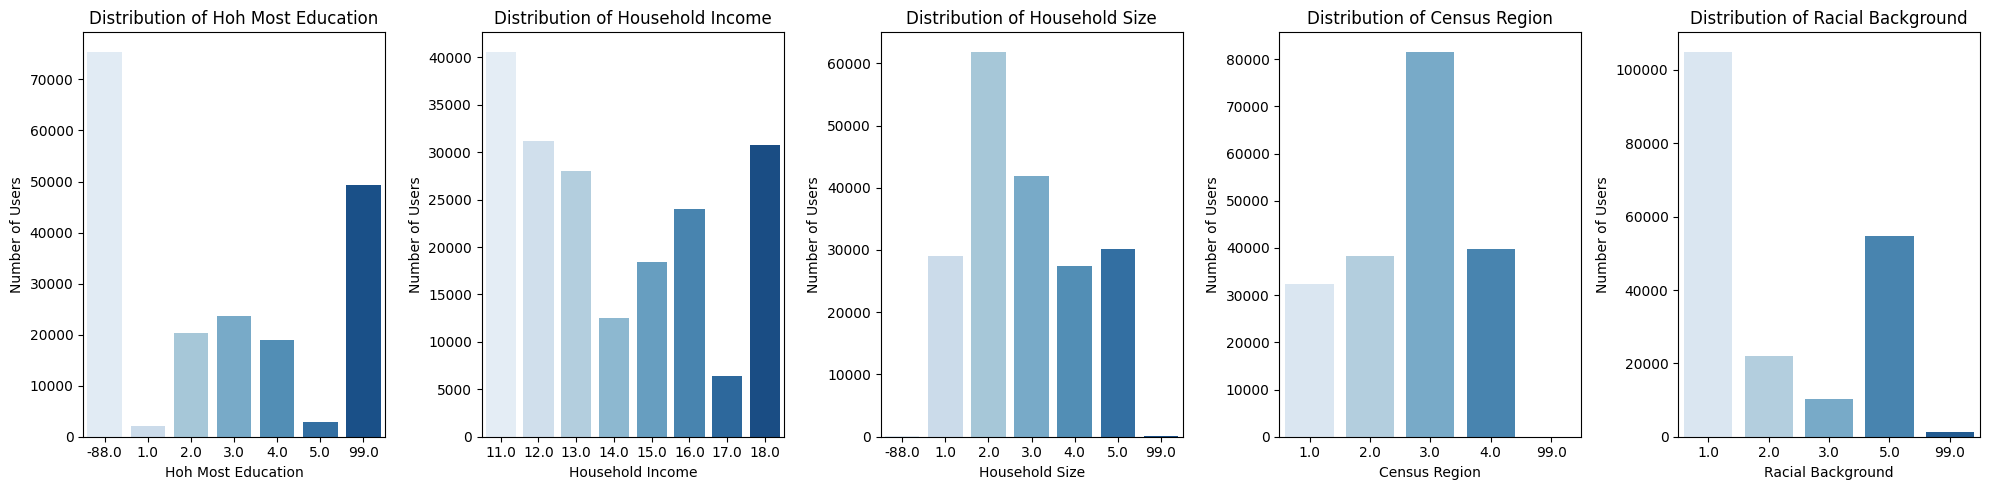

In [5]:
# Define the demographic columns of interest
demographic_cols = [
    'hoh_most_education', 
    'household_income', 
    'household_size', 
    'census_region', 
    'racial_background'
]

#Extract Unique User-Level Demographic Data

user_demo = (
    sessions
    .loc[:, ['machine_id'] + demographic_cols]
    .drop_duplicates(subset='machine_id')
    # Alternatively:
    # .groupby('machine_id')[demographic_cols].first().reset_index()
)


fig, axes = plt.subplots(1, len(demographic_cols), figsize=(20, 5))

for ax, col in zip(axes, demographic_cols):
    # Compute the frequency counts for each category in the column
    counts = user_demo[col].value_counts().sort_index()
    
    blue_palette = sns.color_palette("Blues", n_colors=len(counts))
    
    sns.barplot(x=counts.index, y=counts.values, ax=ax, palette=blue_palette)
    
    ax.set_title(f'Distribution of {col.replace("_", " ").title()}')
    ax.set_xlabel(col.replace("_", " ").title())
    ax.set_ylabel('Number of Users')

plt.tight_layout()
plt.savefig("demo_overall.png", dpi = 300)

plt.show()


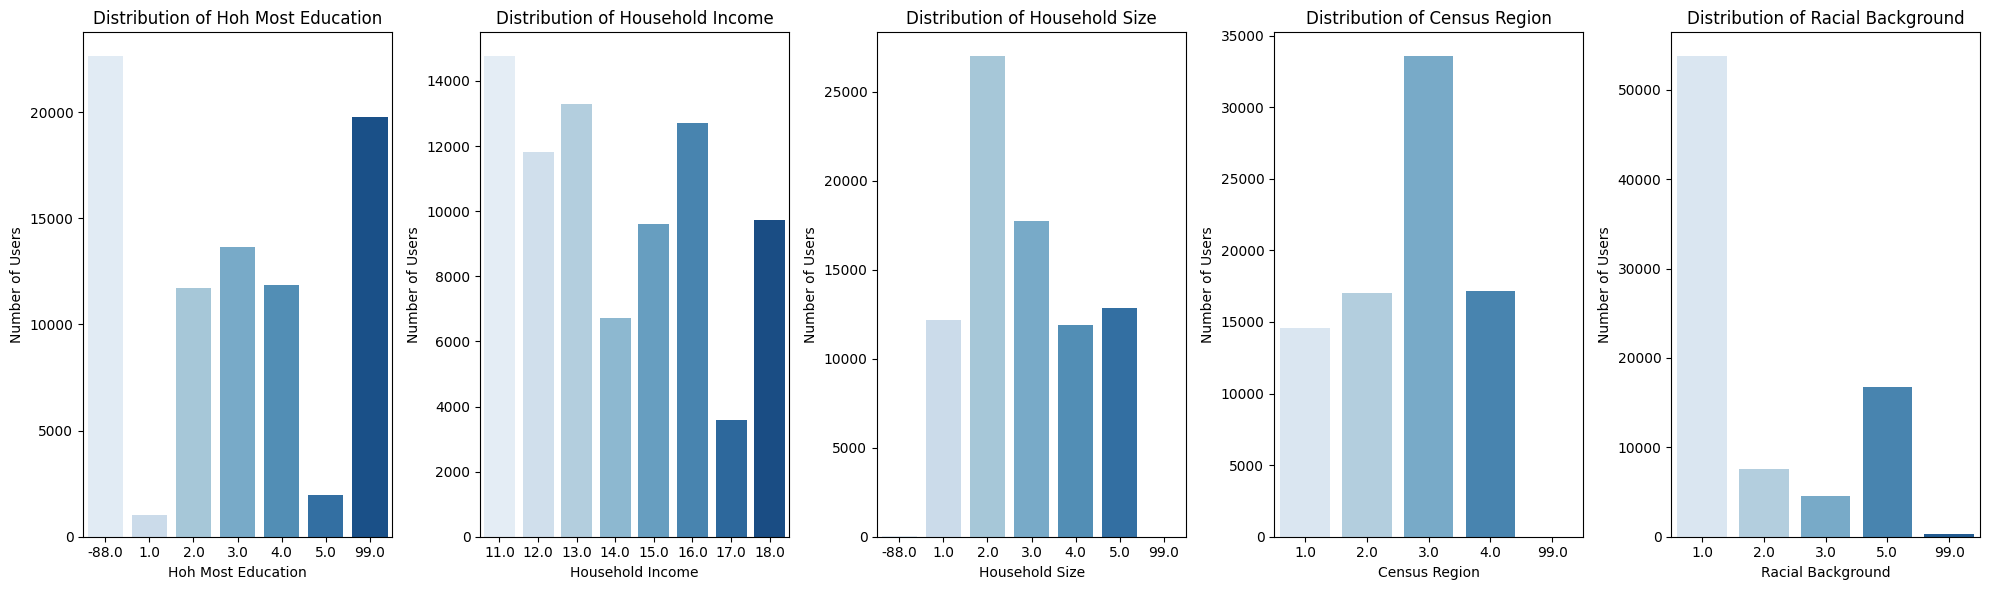

In [6]:

# Demographic Distribution for Successful Sessions

successful_machine_ids = transactions['machine_id'].unique()

# Filter the sessions DataFrame to include only those sessions where a transaction occurred.
sessions_successful = sessions[sessions['machine_id'].isin(successful_machine_ids)]

# Retrieve unique user-level demographic information by selecting one record per machine ID.
successful_user_demo = (
    sessions_successful
    .loc[:, ['machine_id'] + demographic_cols]
    .drop_duplicates(subset='machine_id')
    # Alternatively, you could use:
    # .groupby('machine_id')[demographic_cols].first().reset_index()
)


fig, axes = plt.subplots(1, len(demographic_cols), figsize=(20, 6))

for ax, col in zip(axes, demographic_cols):
    # Calculate frequency counts for each category of the demographic variable
    counts = successful_user_demo[col].value_counts().sort_index()
    blue_palette = sns.color_palette("Blues", n_colors=len(counts))
    
    
    sns.barplot(x=counts.index, y=counts.values, ax=ax, palette=blue_palette)
    
    ax.set_title(f'Distribution of {col.replace("_", " ").title()}')
    ax.set_xlabel(col.replace("_", " ").title())
    ax.set_ylabel('Number of Users')


plt.tight_layout()
plt.savefig("demo_successful.png", dpi = 300)
plt.show()


# Domain-wise Distribution in Transaction Data
Amazon.com makes up most of the transaction data

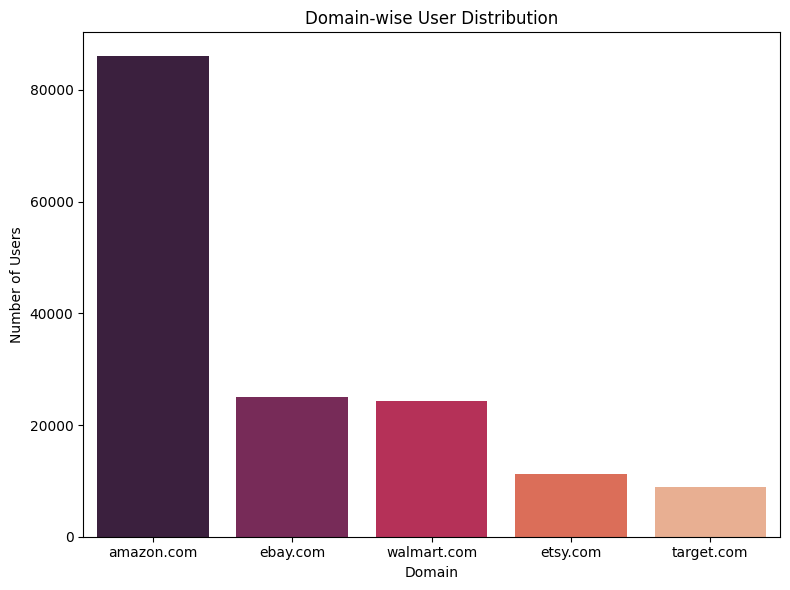

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


trans_user_brands = (
    transactions
    .loc[:, ['machine_id', 'domain_name']]
    .drop_duplicates()
    # Alternatively, the following code can be used to group by brand and count unique users:
    # transactions.groupby('domain_name')['machine_id'].nunique().sort_values(ascending=False)
)

brand_group_counts = trans_user_brands['domain_name'].value_counts()

plt.figure(figsize=(8, 6))

sns.barplot(x=brand_group_counts.index, y=brand_group_counts.values, palette='rocket')

plt.title('Domain-wise User Distribution')
plt.xlabel('Domain')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.savefig("brand_dist.png", dpi = 300)
plt.show()


In [8]:
trans_user_brands.shape

(155311, 2)

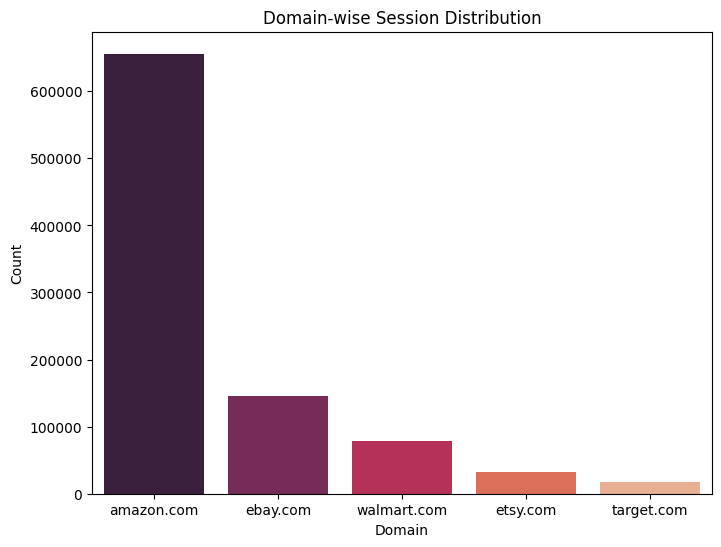

In [9]:
# Brand-wise Distribution in Transaction Data

trans_user_brands = (
    transactions
    .loc[:, ['machine_id', 'event_date', 'domain_name']]
    .drop_duplicates()
    # or equivalently:
    # .groupby('machine_id')[demographic_cols].first().reset_index()
)

# trans_user_brands = (
#     transactions
#     .groupby('domain_name')['machine_id']
#     .nunique()
#     .sort_values(ascending=False)
# )
# Plot the brand-wise distribution
plt.figure(figsize=(8, 6))
brand_group_counts = trans_user_brands['domain_name'].value_counts()
sns.barplot(x=brand_group_counts.index, y=brand_group_counts.values, palette='rocket')
plt.title('Domain-wise Session Distribution')
plt.xlabel('Domain')
plt.ylabel('Count')
plt.show()

## Conversion Rate Analysis

- Conversion Rate by Pages Viewed -> Conversion Rate is higher if the number of pages viewed are higher
- Conversion Rate by Duration of Session -> More Duration means higher chance of conversion
- Hour of the day -> Conversion happens mostly during evening and night
- Day of the week -> Higher conversion rate during the weekend

In [10]:
converted_sessions = (
    transactions[['machine_id','event_date']]
    .drop_duplicates()
    .assign(converted=1)
)

# join back to sessions
sessions_full = (
    sessions
    .merge(converted_sessions, on=['machine_id','event_date'], how='left')
    .assign(converted=lambda df: df['converted'].fillna(0).astype(int))
)

In [11]:
bins = [0,1,3,5,10,20,50,100]
labels = ['0-1','2-3','4-5','6-10','11-20','21-50','51+']
sessions_full['pages_bucket'] = pd.cut(sessions_full['pages_viewed'], bins=bins, labels=labels, right=False)

# compute conversion rate per bucket

page_conv = (
    sessions_full.groupby('pages_bucket')['converted']
    .agg(['mean','count'])
    .rename(columns={'mean':'conv_rate','count':'n_sessions'})
    .reset_index()
)

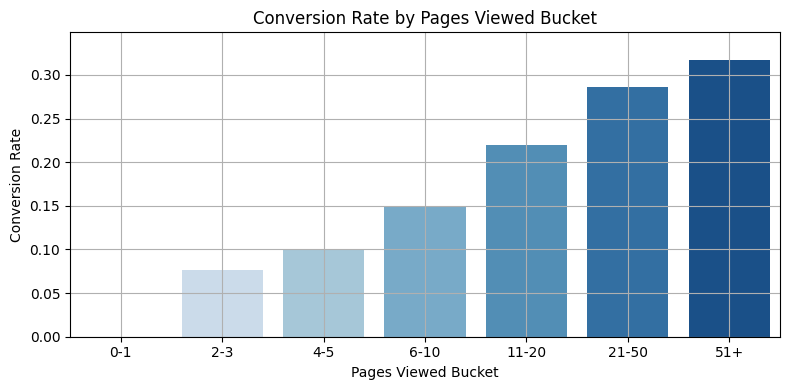

In [12]:
plt.figure(figsize=(8,4))
sns.barplot(x = page_conv['pages_bucket'], y = page_conv['conv_rate'], palette="Blues")
plt.xlabel('Pages Viewed Bucket')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Pages Viewed Bucket')
plt.ylim(0, page_conv['conv_rate'].max() * 1.1)
plt.grid()
plt.tight_layout()
plt.savefig("page_viewed.png", dpi = 300)
plt.show()

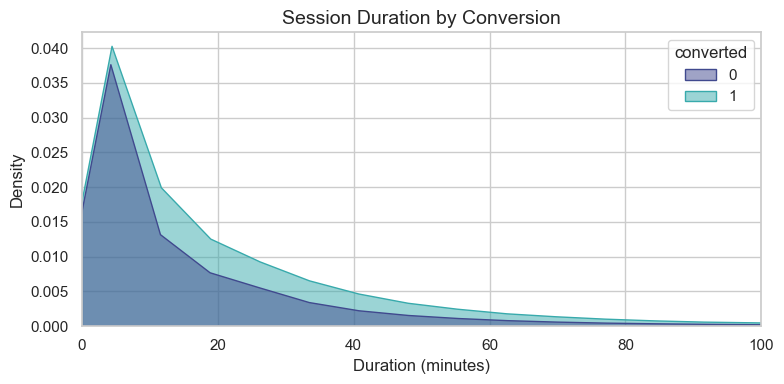

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 4))

ax = sns.kdeplot(
    data=sessions_full,
    x='duration',
    hue='converted',
    common_norm=False,
    fill=True,        
    alpha=0.5,       
    palette='mako'    
)

plt.xlim(0, sessions_full['duration'].quantile(0.99))

plt.title('Session Duration by Conversion', fontsize=14)
plt.xlabel('Duration (minutes)', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.tight_layout()
plt.savefig("sessionDuration.png", dpi = 300)
plt.show()


### Hour of the day and day of the week analysis

In [14]:
# extract hour and weekday
sessions_full['event_date'] = pd.to_datetime(sessions_full['event_date'])

# extract hour by splitting on ':' and converting to int
sessions_full['event_time_parsed'] = pd.to_datetime(
    sessions_full['event_time'],
    format='%H:%M:%S',
    errors='coerce'            # invalid/missing → NaT
)
sessions_full['hour'] = sessions_full['event_time_parsed'].dt.hour
valid_sessions = sessions_full.dropna(subset=['hour'])
# extract weekday name
sessions_full['weekday'] = sessions_full['event_date'].dt.day_name()

# conversion by hour
hourly = (
    valid_sessions
    .groupby('hour')['converted']
    .mean()
    .reset_index(name='conv_rate')
)

# conversion by weekday (order Mon–Sun)
weekday = (
    sessions_full.groupby('weekday')['converted']
    .mean()
    .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    .reset_index()
)


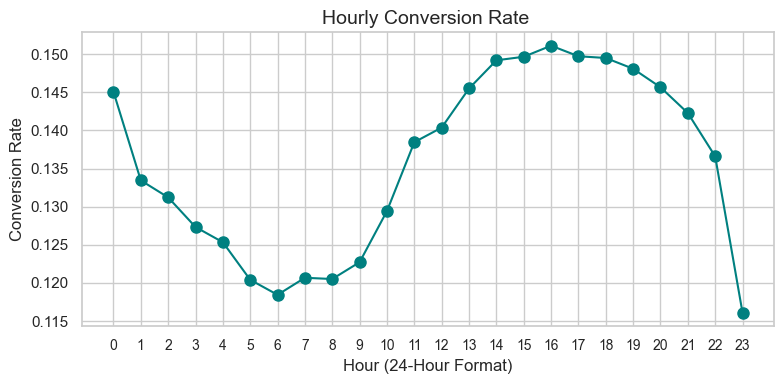

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Hourly Conversion Rate Analysis

plt.figure(figsize=(8, 4))
plt.plot(hourly['hour'], hourly['conv_rate'], marker='o', linestyle='-', color='teal', markersize=8)
plt.xticks(range(0, 24), fontsize=10)
plt.xlabel('Hour (24-Hour Format)', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.title('Hourly Conversion Rate ', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("hourly_rate.png", dpi = 300)
plt.show()


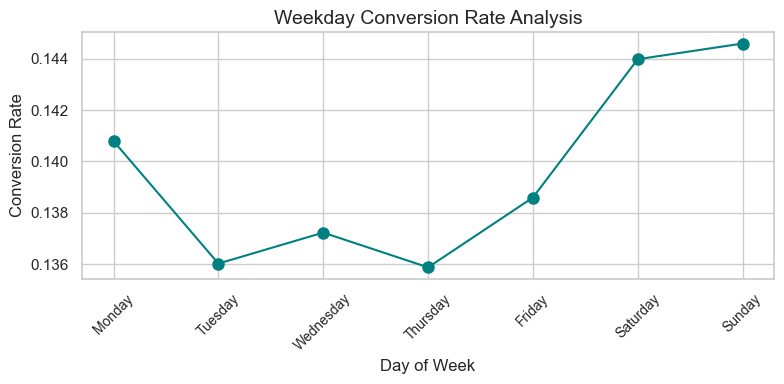

In [16]:

# Weekday Conversion Rate Analysis

plt.figure(figsize=(8, 4))
plt.plot(weekday['weekday'], weekday['converted'], marker='o', linestyle='-', color='teal', markersize=8)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.title('Weekday Conversion Rate Analysis', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("day_rate.png", dpi = 300)

plt.show()


### Conversion Rate by Referral Type

In [17]:
def bucket_ref(ref):
    if pd.isna(ref):
        return 'direct'
    r = ref.lower()
    # search engines
    if any(x in r for x in ['google','bing','yahoo']):
        return 'search'
    # social media
    if any(x in r for x in ['facebook','twitter','instagram','pinterest']):
        return 'social'
    # major marketplaces
    if any(x in r for x in ['amazon.', 'ebay.', 'walmart.', 'etsy.', 'target.']):
        return 'marketplace'
    return 'other'

sessions_full['ref_bucket'] = sessions_full['ref_domain__name'].apply(bucket_ref)

ref_conv = (
    sessions_full
    .groupby('ref_bucket')['converted']
    .mean()
    .reset_index(name='conv_rate')
)


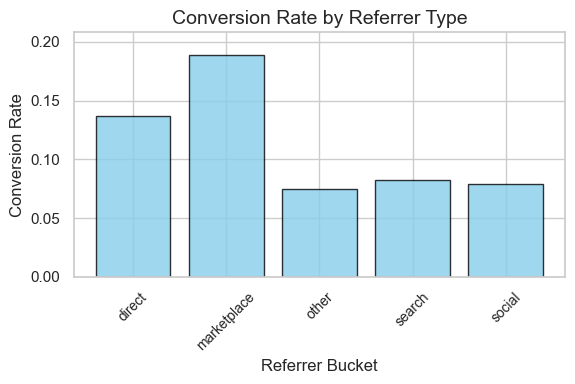

In [18]:


sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 4))


plt.bar(ref_conv['ref_bucket'],
        ref_conv['conv_rate'],
        color='skyblue',
        edgecolor='black',
        alpha=0.8)

plt.xlabel('Referrer Bucket', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.title('Conversion Rate by Referrer Type', fontsize=14)

plt.ylim(0, ref_conv['conv_rate'].max() * 1.1)

plt.xticks(fontsize=10, rotation=45)

plt.tight_layout()
plt.savefig("refer_type.png", dpi  = 300)
plt.show()


### Money Spent per session
- Most of the user spent under $50 

In [19]:
sess_demo = sessions_full[['machine_id','event_date','household_income']].drop_duplicates()

tx_agg = (
    transactions
    .groupby(['machine_id','event_date'])
    .agg(
        # basket_tot is identical on every row for that session, so take max
        basket_tot=('basket_tot','max'),
        # total number of items purchased
        total_qty=('prod_qty','sum'),
        # distinct products purchased
        distinct_products=('prod_category_id','nunique')
    )
    .reset_index()
)


In [20]:
tx_agg = tx_agg.merge(sess_demo, on=['machine_id','event_date'], how='left')

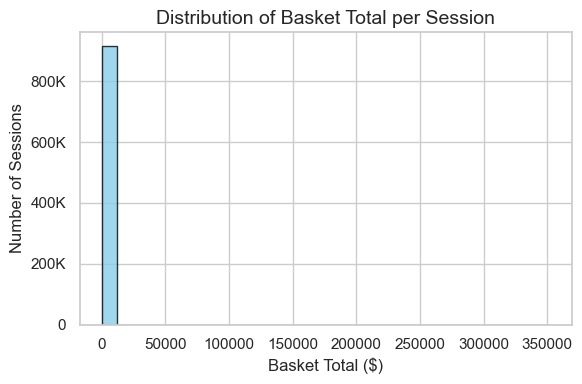

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 4))


plt.hist(tx_agg['basket_tot'], bins=30, color='skyblue', edgecolor='black', alpha=0.8)


plt.title('Distribution of Basket Total per Session', fontsize=14)
plt.xlabel('Basket Total ($)', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))

plt.tight_layout()
plt.show()


### 99th percentile

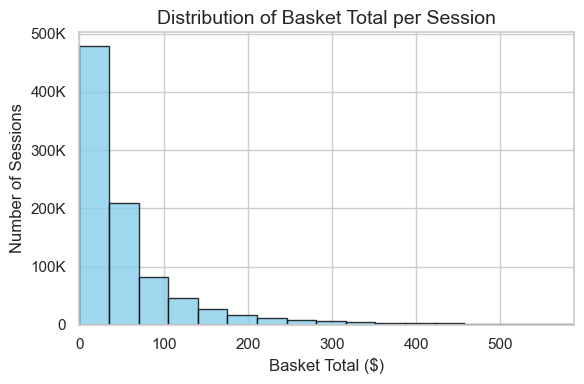

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter


sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 4))

p99 = tx_agg['basket_tot'].quantile(0.99)

plt.hist(tx_agg['basket_tot'], bins=10000, color='skyblue', edgecolor='black', alpha=0.8)

plt.xlim(0, p99)

plt.title('Distribution of Basket Total per Session', fontsize=14)
plt.xlabel('Basket Total ($)', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))

plt.tight_layout()
plt.savefig("basket_total.png", dpi = 300)
plt.show()


Money spent by user belonging to different income bands

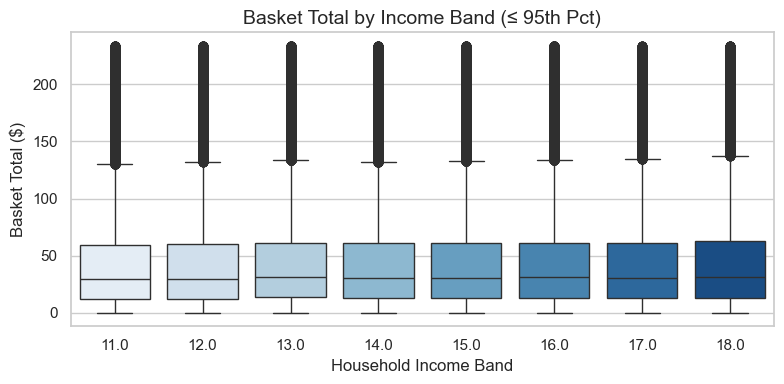

In [23]:


cutoff = tx_agg['basket_tot'].quantile(0.95)

filtered = tx_agg[tx_agg['basket_tot'] <= cutoff]

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 4))

sns.boxplot(
    x='household_income',
    y='basket_tot',
    data=filtered,
    palette="Blues"
)

plt.xlabel('Household Income Band', fontsize=12)
plt.ylabel('Basket Total ($)', fontsize=12)
plt.title('Basket Total by Income Band (≤ 95th Pct)', fontsize=14)

plt.tight_layout()
plt.show()


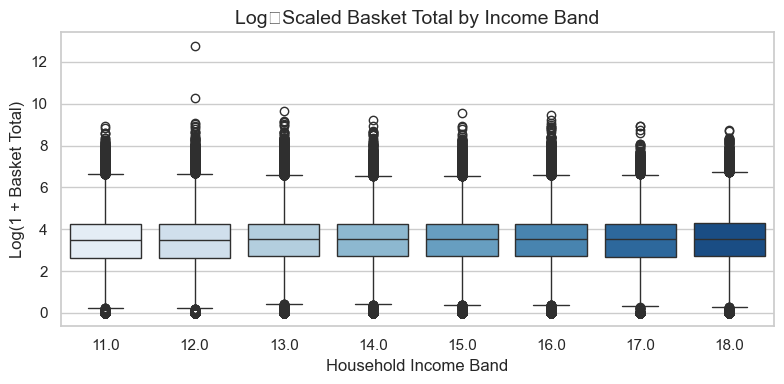

In [24]:
sns.set_theme(style="whitegrid")

tx_agg['log_basket_tot'] = np.log1p(tx_agg['basket_tot'])

plt.figure(figsize=(8, 4))
sns.boxplot(
    x='household_income',
    y='log_basket_tot',
    data=tx_agg,
    palette="Blues"
)

plt.xlabel('Household Income Band', fontsize=12)
plt.ylabel('Log(1 + Basket Total)', fontsize=12)
plt.title('Log‑Scaled Basket Total by Income Band', fontsize=14)

plt.tight_layout()
plt.show()


### Number of different products user buy

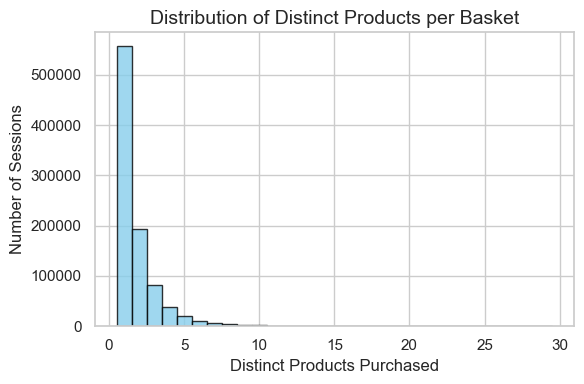

In [25]:

sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 4))

max_distinct = tx_agg['distinct_products'].max()

plt.hist(
    tx_agg['distinct_products'], 
    bins=range(1, max_distinct + 2), 
    align='left', 
    color='skyblue', 
    edgecolor='black', 
    alpha=0.8
)

plt.xlabel('Distinct Products Purchased', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.title('Distribution of Distinct Products per Basket', fontsize=14)

plt.tight_layout()
plt.savefig("distinct_products.png", dpi = 300)
plt.show()


### Top 10 Product category that are converted to buy

In [26]:
tx_cats = (
    transactions[['machine_id','event_date','prod_category_id']]
    .drop_duplicates()
    .merge(prod_cat[['Product Category ID','Report Category']],
           left_on='prod_category_id', right_on='Product Category ID',
           how='left')
)

In [27]:
conv_sessions = sessions_full[sessions_full['converted']==1][['machine_id','event_date']].drop_duplicates()
total_conv = len(conv_sessions)

# Sessions per category
cat_counts = (
    tx_cats.merge(conv_sessions, on=['machine_id','event_date'])
    .groupby('Report Category')['event_date']
    .nunique()
    .reset_index(name='n_sessions')
)
cat_counts['share'] = cat_counts['n_sessions'] / total_conv

# Top 10 categories
top10 = cat_counts.sort_values('share', ascending=False).head(10)

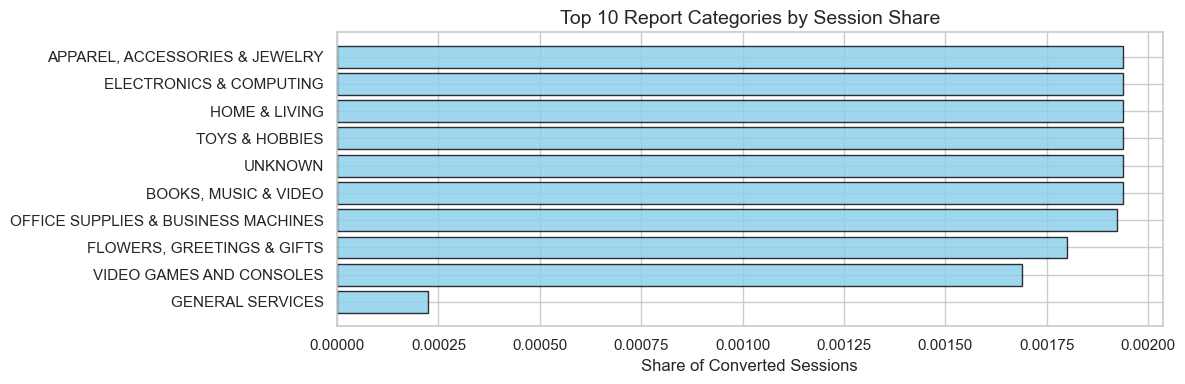

In [28]:

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 4))

plt.barh(top10['Report Category'][::-1], top10['share'][::-1],
         color='skyblue', edgecolor='black', alpha=0.8)

plt.xlabel('Share of Converted Sessions', fontsize=12)
plt.title('Top 10 Report Categories by Session Share', fontsize=14)

plt.tight_layout()

plt.show()


In [29]:
last_sess = sessions_full.groupby('machine_id')['event_date'] \
                    .max().reset_index(name='last_session_date')
last_purch= transactions.groupby('machine_id')['event_date'] \
                    .max().reset_index(name='last_purchase_date')
freq_sess = sessions_full.groupby('machine_id')['event_date'] \
                    .nunique().reset_index(name='freq_sessions')
freq_conv = (
    sessions_full[sessions_full['converted']==1]
    .groupby('machine_id')['event_date']
    .nunique().reset_index(name='freq_conversions')
)

In [30]:
# Monetary: avg spend per session
basket = (
    transactions
    .groupby(['machine_id','event_date'])
    .agg(basket_tot=('basket_tot','max'))
    .reset_index()
)
monetary = (
    basket
    .groupby('machine_id')
    .agg(total_spend=('basket_tot','sum'),
         n_sessions=('event_date','nunique'))
    .assign(avg_spend_per_session=lambda df: df['total_spend']/df['n_sessions'])
    .reset_index()
)

In [31]:
obs_start = pd.Timestamp('2020-01-01')
obs_end   = pd.Timestamp('2023-12-31')

In [32]:
user = (
    last_sess
    .merge(last_purch, on='machine_id', how='left')
    .merge(freq_sess, on='machine_id', how='left')
    .merge(freq_conv, on='machine_id', how='left')
    .merge(monetary, on='machine_id', how='left')
    .fillna({'last_purchase_date': obs_end, 'freq_conversions': 0, 'avg_spend_per_session': 0})
    .assign(
        recency_session = lambda df: (obs_end - df['last_session_date']).dt.days,
        recency_purchase= lambda df: (obs_end - df['last_purchase_date']).dt.days,
        conv_rate       = lambda df: df['freq_conversions'] / df['freq_sessions']
    )
)

In [33]:

from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid")

def plot(col, xlabel, ylabel='Number of Users', save=False, name=""):
    """
    Plots a histogram for a specified column in the 'user' DataFrame.

    Parameters:
        col (str): The column name in the 'user' DataFrame to be plotted.
        xlabel (str): The label for the x-axis.
        ylabel (str): The label for the y-axis (default: 'Number of Users').
        save (bool): Whether to save the plot (default: False).
        name (str): The filename to save the plot if 'save' is True.
    """
    plt.figure(figsize=(6, 3))
    
    plt.hist(user[col].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.8)
    
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f'User Distribution: {xlabel}', fontsize=14)
    
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))
    
    plt.tight_layout()
    
    if save:
        plt.savefig(name, dpi=300)
    
    plt.show()


### User Distribution for different behavioral metrics

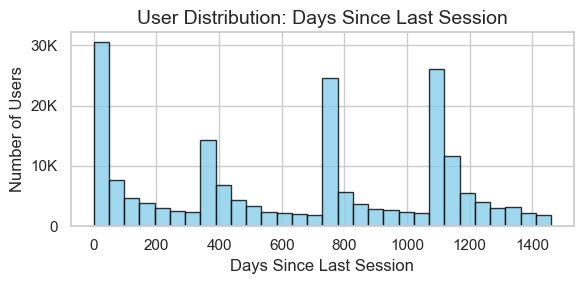

In [34]:
plot('recency_session', 'Days Since Last Session', 'Number of Users', True, name = "days_last_session.png")

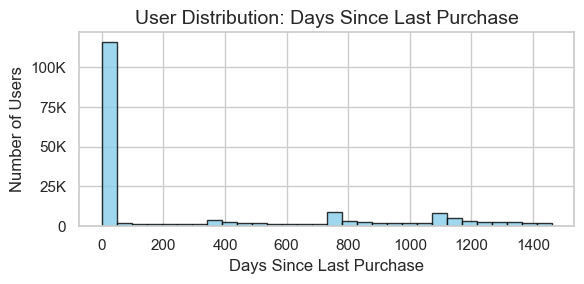

In [35]:
plot('recency_purchase', 'Days Since Last Purchase', 'Number of Users', True, name = "days_last_purchase.png")

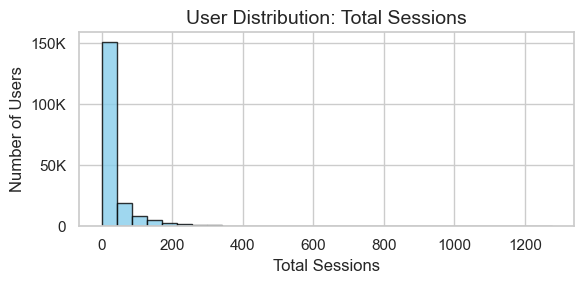

In [36]:
plot('freq_sessions', 'Total Sessions', 'Number of Users')

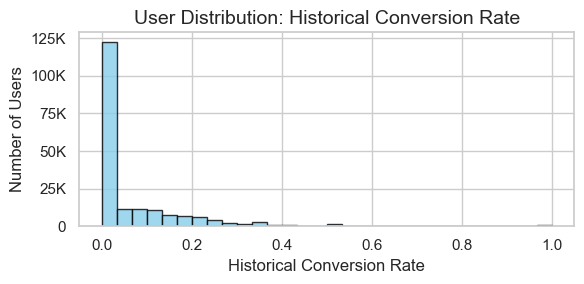

In [37]:
plot('conv_rate', 'Historical Conversion Rate', 'Number of Users', save = True, name = "historical_conversion.png")

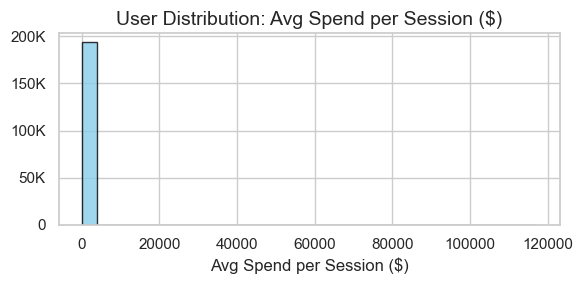

In [38]:
plot('avg_spend_per_session', 'Avg Spend per Session ($)', '')

### Conversion Rate vs Different Census Metric

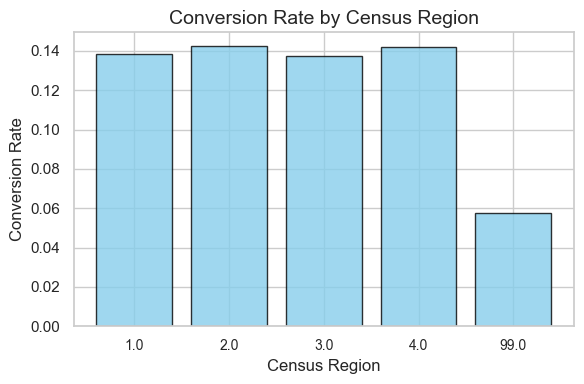

In [39]:

sns.set_theme(style="whitegrid")

geo = (
    sessions_full.groupby('census_region')['converted']
        .agg(conv_rate='mean', n_sessions='count')
        .reset_index()
)

plt.figure(figsize=(6, 4))
plt.bar(geo['census_region'].astype(str), geo['conv_rate'],
        color='skyblue', edgecolor='black', alpha=0.8)

plt.xlabel('Census Region', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.title('Conversion Rate by Census Region', fontsize=14)

plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()


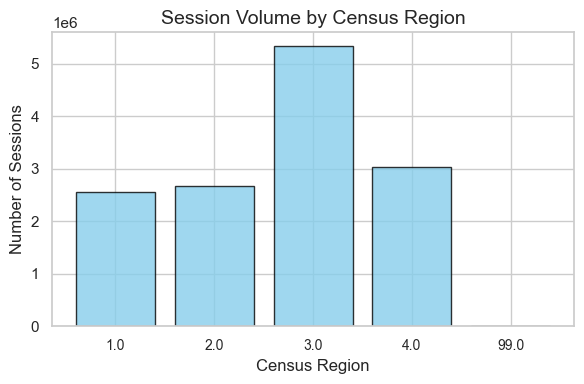

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 4))

plt.bar(geo['census_region'].astype(str), geo['n_sessions'],
        color='skyblue', edgecolor='black', alpha=0.8)

plt.xlabel('Census Region', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.title('Session Volume by Census Region', fontsize=14)

plt.xticks(fontsize=10)
plt.tight_layout()

# Display the final plot
plt.show()


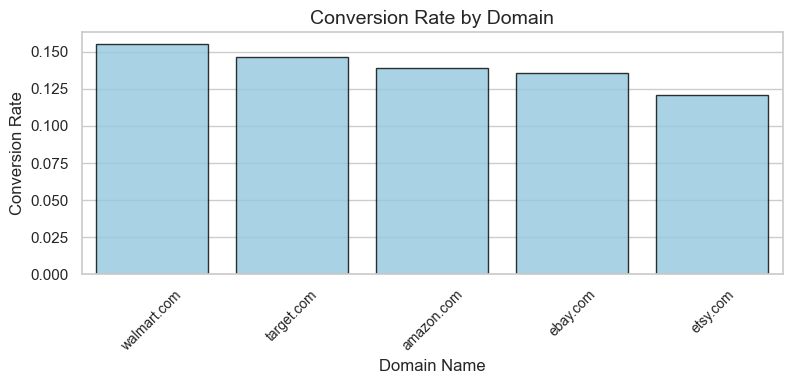

In [41]:

sns.set_theme(style="whitegrid")

ref_conv = (
    sessions_full.groupby('domain_name')['converted']
    .mean()
    .reset_index(name='conv_rate')
    .sort_values('conv_rate', ascending=False)
)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=ref_conv,
    x='domain_name',
    y='conv_rate',
    color='skyblue',
    edgecolor='black',
    alpha=0.8
)

plt.xlabel('Domain Name', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.title('Conversion Rate by Domain', fontsize=14)

plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()
